# [WIP] Spin echo simulation

## Libraries
The cells below include libraries that will be useful in the process of the simulation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Functions
The cells below denote functions that will be useful for the simulation.

In [56]:
def new_range(img : np.ndarray, min = 0.0, max = 1.0):
  '''Function that converts an array to the given desired range.'''
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min


def normalize(vec : np.ndarray) -> np.ndarray:
  """Normalizes an array or a set of arrays.

  Parameters
  ----------
  vec : np.ndarray (N, M)
    Array to be normalized."""
  return vec/np.tile(np.linalg.norm(vec, axis = 0), vec.shape[0]).reshape(vec.shape)
  
def rotation_matrix(alpha : float, beta : float, gamma : float):
    """Returns the final rotation matrix from the multiplication 
    of the three rotation matrices in the following order: Rxy*Rxz*Ryz, 
    which means it first rotates around the x axis, then around the y axis, 
    then around the z axis. 

    The matrix of rotations are:

    Rxy = np.matrix([[ np.cos(alpha), np.sin(alpha), 0.0], 
                     [-np.sin(alpha), np.cos(alpha), 0.0], 
                     [           0.0,           0.0, 1.0]])
    
    Rxz = np.matrix([[  np.cos(beta),           0.0,           np.sin(beta)], 
                     [         0.0,            1.0,                   0.0], 
                     [ -np.sin(beta),           0.0,           np.cos(beta)]])
    
    Ryz = np.matrix([[ 1.0,              0.0,             0.0], 
                     [ 0.0,    np.cos(gamma),   np.sin(gamma)], 
                     [ 0.0,   -np.sin(gamma),   np.cos(gamma)]])
    
    Parameters
    ----------
    alpha : float
      angle of rotation around the z axis.
    beta : float
      angle of rotation around the y axis.
    gamma : float
      angle of rotation around the x axis.
      
    """

    
    R = np.matrix([[np.cos(alpha)*np.cos(beta), np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma) + np.sin(alpha)*np.sin(gamma)], 
                   [np.sin(alpha)*np.cos(beta), np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) - np.cos(alpha)*np.sin(gamma)], 
                   [-np.sin(beta), np.cos(beta)*np.sin(gamma), np.cos(beta)*np.cos(gamma)]])
    
    return R

def rotate(vec : np.ndarray, alpha : float, beta : float, gamma : float):
    """Rotates a 3D array or set of arrays by a certain set of angles, in radians. 
    The order of rotation is Rxy*Rxz*Ryz, so it first rotates around 
    the x axis, then around the y axis, then around the z axis. 
    
    Parameters
    ----------
    vec : np.ndarray (N, 3)
      Array to be rotated.
    alpha : float
      angle of rotation around the z axis.
    beta : float
      angle of rotation around the y axis.
    gamma : float
      angle of rotation around the x axis.
      
    """
    
    R = rotation_matrix(alpha, beta, gamma)
    
    return np.asarray((R*np.matrix(vec).T).T)


def apply_B(M : np.ndarray, B : np.ndarray, gamma : float, dt : float):
  """Applies a magnetic field B onto a magnetic moment M in a 
     certain interval dt, making it rotate about an angle w*dt, 
     with w = gamma*B_z, gamma being the gyromagnetic ratio of 
     the nucleus, and B_z the component of the magnetic field 
     orthogonal to the magnetic moment.
     
     Parameters
     ----------
     
     M : np.ndarray
      The magnetic moment of the atom
     B : np.ndarray
      The magnetic field to be applied.
     gamma : float
      The gyromagnetic moment of the nucleus
     dt : float
      The value of the simulation's dt"""

  x = normalize(M)
  y = np.cross(x, normalize(B))
  z = np.cross(x, y)

  B_z = np.dot(B, z)

  w = gamma*B_z
  f = w/(2.0*np.pi)

  angle = f*dt

  #first, a new coordinate system is defined 
  #so the rotations can be done in terms of angle
  new_coord = np.matrix([x,
                         y,
                         z]).T
  
  #it is also important to understand how do the original coordinate
  #system changes in the new one, so we can use it to come back
  
  #the vector is translated into the new coordinate system
  new_vec = np.array(new_coord*(np.matrix(M).T)).T[0]

  #the rotation is done
  rotated = rotate(new_vec, -angle, 0.0, 0.0)

  #we come back to the old coordinate system now with a rotated vector
  #by multiplying the vector with the inverse matrix of the transformation,
  #which is only the transpose matrix due to its orthonormality
  back = np.array((new_coord.T*np.matrix(rotated).T)).T[0]
  
  return back


def bloch_eq(M : np.ndarray, M0 : np.ndarray, B : np.ndarray, gamma : float, T1: float, T2: float, dt : float, debug : bool = False):

  if debug:
    print("M :", M)
    print("B :", B)
    print("MxB :", np.cross(M, B))

  # m1[0] = M[0] + (gamma*MxB[0] - (M[0])/T2)*dt
  # m1[1] = M[1] + (gamma*MxB[1] - (M[1])/T2)*dt
  # m1[2] = M[2] + (gamma*MxB[2] - (M[2] - M0[2])/T1)*dt
    
  # relax = np.array([(M[0])/T2, (M[1])/T2, (M[2] - M0[2])/T1])

  return M + gamma*np.cross(M, B)*dt 

In [4]:
m1 = np.array([0.0, 0.0, 1.0])

t0 = 0.0
tn = 10.0
dt = 0.001

t = np.arange(t0, tn, dt)

gamma = ((tn-t0)/dt)/10.0

B0 = np.array([0.0, 0.0, 1.0])

## Experimental
The cells below are to experiment the features to be implemented to functions.

In [5]:
n = 3

u = 1.0

spins = np.random.rand(n, 3)

In [6]:
v = np.array([0.0, 1.0, 0.0])

vl = rotate(v, 0.0, 0.0, np.pi/2)

print(v)
print(vl)


[0. 1. 0.]
[[0.000000e+00 6.123234e-17 1.000000e+00]]


In [7]:
# Experimental

u = np.array([0.0, 0.0, 1.0])
v = np.array([0.0, 1.0, 0.0])
w = np.array([1.0, 0.0, 0.0])

R = rotation_matrix(np.pi/2, 0.0, 0.0)

R[np.abs(R) < 10e-17] = 0.0
I = np.matrix(np.eye(3, 3))
C = R*I

print(I)

print(R)

print(C)

mat = np.matrix([u, 
                 v, 
                 w]).T

print(mat)

vec = np.array([1.0, 0.0, 0.0])

print("Original vector :", vec)

changed = np.array((R*np.matrix(vec).T)).T[0]

print("Changed vector :", changed)

# rotated = rotate()

print("Comeback vector :", np.array(R.T*np.matrix(changed).T).T[0])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Original vector : [1. 0. 0.]
Changed vector : [0. 1. 0.]
Comeback vector : [1. 0. 0.]


In [86]:
m0 = np.array([0.0, 0.0, 1.0])
m1 = np.copy(m0)

t0 = 0.0
tn = 100.0
dt = 0.001

t = np.arange(t0, tn, dt)

gamma = (tn - t0)/dt/4.0

B1 = np.array([0.0, 1.0, 0.0])
T1 = 6.0
T2 = 5.0
phi = 0.0

M_x = np.zeros(t.shape[0])
M_y = np.zeros(t.shape[0])
M_z = np.zeros(t.shape[0])

M_x[0] = m0[0]
M_y[0] = m0[1]
M_z[0] = m0[2]

for i in range(1, t.shape[0]):
    # B = B1*np.sin((gamma/2*np.pi)*t[i] + phi)
    B = B1
    # m1 = bloch_eq(m1, m0, B1*np.sin((gamma/2*np.pi)*t[i] + phi), gamma, T1, T2, dt)
    m1 = apply_B(m1, B, gamma, dt)
    M_x[i] = m1[0]
    M_y[i] = m1[1]
    M_z[i] = m1[2]



C:\Users\Lampada\AppData\Local\Temp\ipykernel_18304\4276203424.py:13: RuntimeWarning: divide by zero encountered in divide
  return vec/np.tile(np.linalg.norm(vec, axis = 0), vec.shape[0]).reshape(vec.shape)
c:\Users\Lampada\anaconda3\envs\mestrado\lib\site-packages\numpy\core\numeric.py:1647: RuntimeWarning: invalid value encountered in multiply
  multiply(a1, b2, out=cp0)
c:\Users\Lampada\anaconda3\envs\mestrado\lib\site-packages\numpy\core\numeric.py:1650: RuntimeWarning: invalid value encountered in multiply
  multiply(a2, b0, out=cp1)
c:\Users\Lampada\anaconda3\envs\mestrado\lib\site-packages\numpy\core\numeric.py:1651: RuntimeWarning: invalid value encountered in multiply
  multiply(a0, b2, out=tmp)
c:\Users\Lampada\anaconda3\envs\mestrado\lib\site-packages\numpy\core\numeric.py:1654: RuntimeWarning: invalid value encountered in multiply
  multiply(a1, b0, out=tmp)


nan


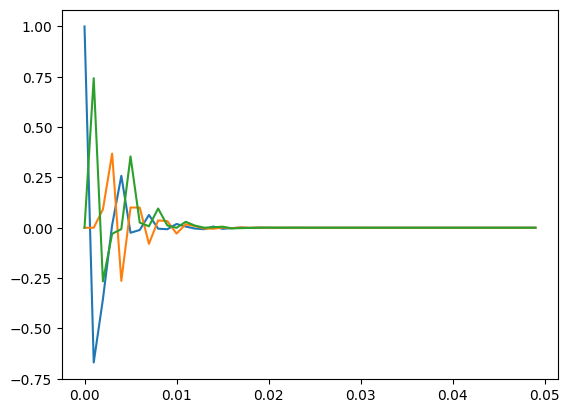

In [87]:
# l = int((tn-t0)/dt)
a = 0
l = 50
plt.plot(t[a:l], M_z[a:l])
plt.plot(t[a:l], M_x[a:l])
plt.plot(t[a:l], M_y[a:l])
print(np.max((M_x + M_y + M_z)[a:]))

In [190]:
B0 = np.array([0.0, 0.0, 0.0])

M_x[0] = m1[0]
M_y[0] = m1[1]
M_z[0] = m1[2]

for i in range(1, t.shape[0]):
    m1 = bloch_eq(m1, m0, B0, gamma, T1, T2, dt)
    M_x[i] = m1[0]
    M_y[i] = m1[1]
    M_z[i] = m1[2]

2324940045660.0127


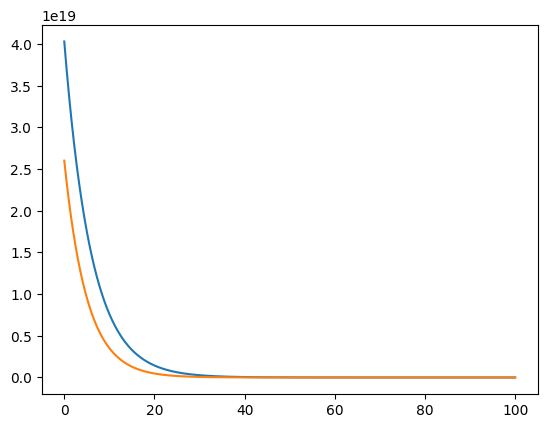

In [191]:
plt.plot(t, M_z)
plt.plot(t, M_x)
print(M_z[-1])

## Simulation
The cells below include the running simulation